In [1]:
%load_ext autoreload
%autoreload 2

## DCR AGN Metric
This notebook will build an metric on top of the prototye shown in [DCR AGN Metric Analysis](https://github.com/RichardsGroup/LSSTprep/blob/master/DCR/DCR_AGN_metric_analysis.ipynb), but with a focus on the integration with MAF and the evaluation of various simulated LSST cadences.

### 0. Software Setup

In [2]:
your_username = 'ywx649999311'

In [3]:
# import matplotlib to show plots inline.wfd_depth_scale0.95_v1.5_10yrs.db
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import matplotlib as mpl
mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

Import the sims_maf modules needed.

In [4]:
# import lsst.sim.maf moduels modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [7]:
# add opsimUtils module path to search
import sys
sys.path.insert(0, '../Scripts_NBs/')

# import convenience functions
from opsimUtils import *

## 1. Read in predicted/true slopes

In [ ]:
data_dir = './DCR_data/'
dfZ = pf.read_csv

## 1. Explore Noise Floor
### 1.1 Investigating how to determine the noise floor given the level of photometrc errors
Since the power spectral density of a random process is just the fourier transform of the process' autovariance function and the autocovariance function of a white noise is a delta function, we can infer that the PSD of a white noise process is just the variance of that process.

Below, we try to domnstrate it using both the FFT and the Lomb Scargle methods. If that is the case, we can approximate the power of measurement noise in light curves using the average (mean/median?) value of the photometric errors. 

In [12]:
# Compute the FFT based power spectrum estimates
N = 10000
var = 0.2
n = np.random.normal(0, np.sqrt(var), N)
t = np.linspace(0, 10000, N)

Mean PSD from FFT: 0.19985751479353328


Text(0, 0.5, 'PSD')

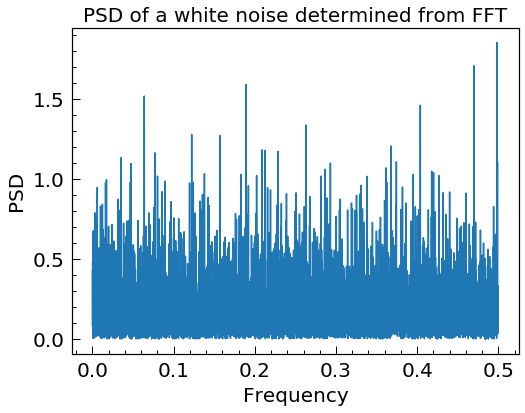

In [23]:
# FFT method
f = np.fft.rfftfreq(len(t), t[1] - t[0])
fft = np.fft.rfft(n)
fft *= np.conj(fft)

# >>> To get the FFT based PSD in the correct units, normalize by N <<<
power_fft = fft.real/N
print(f'Mean PSD from FFT: {power_fft.mean()}')

fig = plt.figure(figsize=(8,6))
plt.plot(f, power_fft)
plt.title('PSD of a white noise determined from FFT', fontsize=20)
plt.xlabel('Frequency')
plt.ylabel('PSD')

Mean PSD from LS: 0.20107429772228744


Text(0, 0.5, 'PSD')

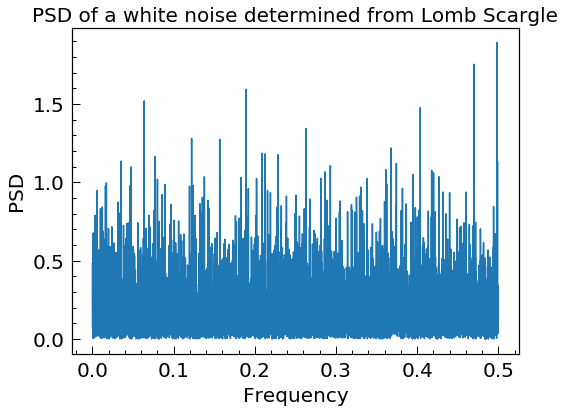

In [24]:
# LS method
from astropy.timeseries import LombScargle

model = LombScargle(t, n)
power_ls = model.power(f[1:], method="fast", normalization="psd")
print(f'Mean PSD from LS: {np.mean(power_ls)}')

fig = plt.figure(figsize=(8,6))
plt.plot(f[1:], power_ls)
plt.title('PSD of a white noise determined from Lomb Scargle', fontsize=20)
plt.xlabel('Frequency')
plt.ylabel('PSD')

### 1.2 The role of noise floor in AGN variability modeling
AGN exhibits excess variability in addition to that induced by the measurement noise and the power of AGN variability is unevenly distributed across the entire frequency domain. Beyond certain timescales/frequencies, the overall variabiliy of AGN light curves (intrinsic + noise) will be dominated by measurement noise, knowing where that turning point is will set an expectation of what we can extract from the light curves. 

Where mesaurement noise dominates the PSD depends on the model used to describe AGN variability. Here we use the Damped Random Walk (DRW) model as the baseline, but try to be as much model independent as possible. Next, I will start with simulating a DRW process with a decorrelation timescale of 100 days and a driving amplitude of 0.1 mag. 

The analytic PSD of a DRW process is:

$$P(f) = \frac{\sigma^{2}\tau^{2}}{1+(2\pi\tau f)^{2}}$$

where $\sigma$ is the amplitude of the driving process and $\tau$ is the decorrelation timescale. Let's plot the PSD with the parameters provided above. I will show two PSDs, one with the noise power included and one without.

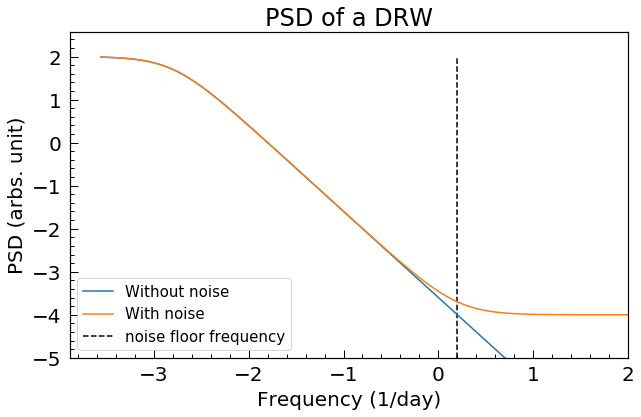

In [60]:
fig = plt.figure(figsize=(10,6))
tau = 100
sigma = 0.1

# psd of DRW
f = np.linspace(np.log10(1/3650), np.log10(1/0.001), 100)
psd = sigma**2*tau**2/(1+ (2*np.pi*tau*np.power(10, f))**2)

# psf of measurement noise assuming measurement error of 0.01 mag
psd_noise = 0.01**2

plt.plot(f, np.log10(psd), label='Without noise')
plt.plot(f, np.log10(psd+psd_noise), label='With noise')
plt.vlines(x=0.2, ymin=-5, ymax=2, linestyles='--', label='noise floor frequency')
plt.xlabel('Frequency (1/day)')
plt.ylabel('PSD (arbs. unit)')
plt.title('PSD of a DRW')
plt.ylim(bottom=-5)
plt.xlim(right=2)
plt.legend(fontsize=15, loc=3)

From the plot above, we can see that the measurement noise becomes dominate at ~5 days given the assumptions we just made. This implies that AGN variability at timescales shorter than 5 days is likely to be undetectable given the level of measurement error and the parameters of the simulated DRW process using light curves. 

The next goal is to determine the timescale ($\tau_{noise}$) at which measurement noise becomes dominate for a variaty of DRW parameters and noise levels. The point is __NOT__ to determine such a timescale for every possible scenario, but to figure out the best possible cadence that AGN variability modeling can take advantage of. Without the lost of generality, we can assume:

- Whatever the model is used, the turnover of the PSD (flattening) at low freqency alwasy exists.
- The lowerst possible decorrelation timescale is 10 days (you will see that the final result should scale linearly with $\tau$)
- We will use the maximum intrinsic variance (light curve variance - noise variance) of AGN variability as determined by MacLeod et al. 2010 based on SDSS Stripe 82 quasars. 
- We will use a PSD of slope -2, as a steeper PSD will only shift the intersection to a lower frequency, thus a longer timescale. 
- We will use the analytic relation between the intrinsic variance and the PSD from the DRW model to predict $\tau_{noise}$

Speaking of the intrinsic variance of a DRW model, it can be determined using:

$$\sigma_{DRW}^{2} = \frac{\sigma^{2}\tau}{2}$$

The maximum PSD of a DRW occurs when $f \to 0$, that leads to $P_{DRW} = \sigma^{2}\tau^{2} = 2\sigma_{DRW}^{2}\tau$. When the noise PSD is small compared to the PSD of the DRW process at the lowest frequency, we can neglect the contribution of power from the measurement noise. Thus we can compute the absolute difference between the PSD plateau (at the lowest frequency) and the noise floor (at the highest frequency) in the log scale as:

$$log_{10}(2\sigma_{DRW}^{2}\tau) - log_{10}(\sigma_{noise}^{2})$$

where $\sigma_{noise}$ is the value of the measurement error. Given a slope of -2 and a hypothetical decorrelation timescale $\tau$, we can determine the $\tau_{noise}$ as:

$$\Delta log(PSD) = 2(\Delta log(f)) $$

$$\Rightarrow log_{10}(2\sigma_{DRW}^{2}\tau) - log_{10}(\sigma_{noise}^{2}) = 2*[log_{10}(f_{noise}) - log_{10}(f_{decorr})]$$

$$\Rightarrow log_{10}(\frac{2\sigma_{DRW}^{2}\tau}{\sigma_{noise}^{2}}) = \
            2*log_{10}(\frac{f_{noise}}{f_{decorr}}) =  log_{10}((\frac{2\pi\tau}{\tau_{noise}})^{2})$$
                                                            
                                                               
$$\Rightarrow \tau_{noise}^{2} = \frac{2\pi^{2}\sigma_{noise}^{2}\tau}{\sigma_{DRW}^{2}}$$

Since $\sigma_{DRW}^{2} < 1/2$ (derived from MacLeod et al. 2010), we get:

$$\tau_{noise}^{2} > \sigma_{noise}^{2}\tau*4\pi^{2} \Rightarrow \tau_{noise} > 6.2832*\sigma_{noise}\sqrt{\tau}$$

If we assume $\tau > 10$ days, then we get:

$$\tau_{noise} > 19.87*\sigma_{noise}$$

For an average photometric error of 0.02 mag, this corresponds to a $\tau_{noise}$ of ~0.4 days. Next we will use the computed photometric errors from simulated survey operations to determine the distribution of $\tau_{noise}$ across the WFD survey. The following work will rely the result produced in [05_YuPhotoErr.ipynb](./05_YuPhotoErr.ipynb) notebook.

### 2. Determine $\tau_{noise}$ using photometric errors dervied from OpSim record
#### 2.1 Read in saved metric data produced in [05_YuPhotoErr.ipynb](./05_YuPhotoErr.ipynb) notebook.

In [25]:
if your_username == '': # do NOT put your username here
    raise Exception('Please provide your username! See the top of the notebook.')

# user provided paths
resultDbPath = '../tmp/PhotoMetric/ResultDBs/'
metricDataPath = '../tmp/PhotoMetric/MetricData/'

In [27]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())

In [51]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts = {}

for runName in resultDbs:
    try:
        bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)
    except:
        print(runName)
        continue

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
footprint_standard_goalsv1.5_10yrs


In [28]:
# we see the available metric keys
list(bundleDicts[runNames[0]].keys())

[(1, 'uMagErrMean_23'), (2, 'gMagErrMean_23')]

#### 2.2 Plot distribution of minimum $\tau_{noise}$
##### 2.2.1 From `uMagErrMean_23`

Text(0.5, 1.0, 'Minimum noise floor timescale for 23rd mag sources in u band')

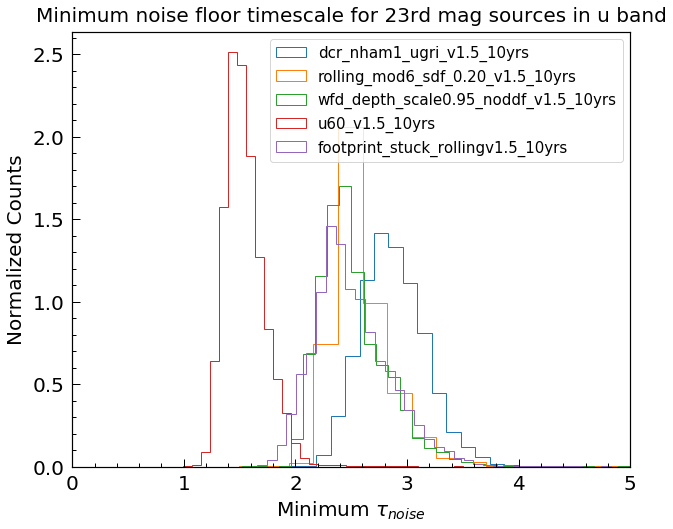

In [76]:
fig = plt.figure(figsize=(10,8))
for runName in runNames[:5]:
    mask = bundleDicts[runName][(1, 'uMagErrMean_23')].metricValues.mask
    data = bundleDicts[runName][(1, 'uMagErrMean_23')].metricValues.data[~mask]
    tau_noise = 19.87*data
    plt.hist(tau_noise, bins=40, histtype='step', label=runName, density=True)
plt.xlim(0,5)
plt.legend(fontsize=15)
plt.xlabel('Minimum $\\tau_{noise}$')
plt.ylabel('Normalized Counts')
plt.title('Minimum noise floor timescale for 23rd mag sources in u band', fontsize=20, pad=10)

##### 2.2.2 From `gMagErrMean_23`

Text(0.5, 1.0, 'Minimum noise floor timescale for 23rd mag sources in g band')

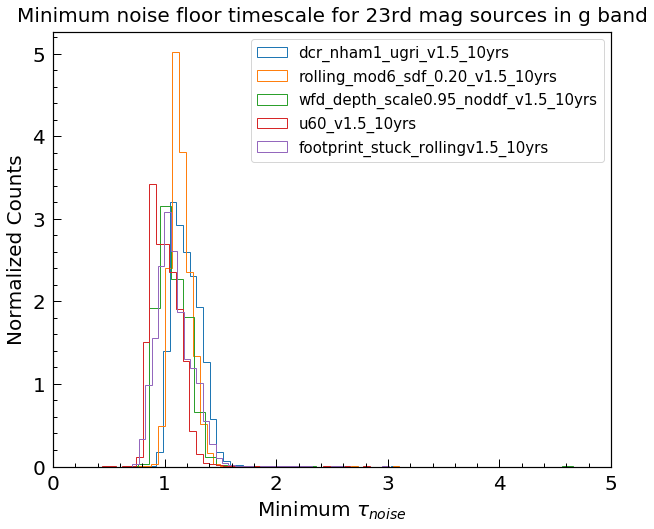

In [77]:
fig = plt.figure(figsize=(10,8))
for runName in runNames[:5]:
    mask = bundleDicts[runName][(2, 'gMagErrMean_23')].metricValues.mask
    data = bundleDicts[runName][(2, 'gMagErrMean_23')].metricValues.data[~mask]
    tau_noise = 19.87*data
    plt.hist(tau_noise, bins=40, histtype='step', label=runName, density=True)
plt.xlim(0,5)
plt.legend(fontsize=15)
plt.xlabel('Minimum $\\tau_{noise}$')
plt.ylabel('Normalized Counts')
plt.title('Minimum noise floor timescale for 23rd mag sources in g band', fontsize=20, pad=10)